# [GD-8] Seq2seq으로 번역기 만들기
## 프로젝트: 한영 번역기 만들기

### 목차
#### 1. 들어가며    
  1-1. seq2seq (Sequence-to-Sequence)        
  1-2. Seq2seq의 인코더        
  1-3. Seq2seq의 디코더        
  1-4. 바다나우 어텐션 함수(Bahdanau Attention Function)        

#### 2. 프로젝트
  2-1. 준비 및 설치        
  2-2. 라이브러리 버전 확인        
  2-3. 데이터셋 : korean-english-news-v1        
  2-4. 데이터 정제        
  2-5. 데이터 토큰화        
  2-6. 모델 설계        
  2-7. 훈련하기        
  2-8. 테스트        

#### 3. 회고
  3-1. 최종 정리        
  3-2. 프로젝트를 진행하면서 알아낸 점, 혹은 아직 모호한 점        
  3-3. 참고사이트        



### 루브릭 평가 기준
|평가문항|상세기준|
|:---|:---|
|1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.|구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.|
|2. Attentional Seq2seq 모델이 정상적으로 구동된다.|seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.|   
<br/>

----


## 2. 프로젝트
### 2-1. 준비 및 설치

#### Google Drive Connect

In [ ]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 한글 글씨 설치

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


#### 한국어 폰트 변경

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


#### 패키지 설치 

In [ ]:
!python3 -m pip install --upgrade pip
!python3 -m pip install konlpy        # Python 3.x

     |████████████████████████████████| 2.1 MB 5.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.0/449.0 KB 25.9 MB/s eta 0:00:00


In [ ]:
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Installing automake (A dependency for mecab-ko)
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B

In [ ]:
!pip3 install /tmp/mecab-python-0.996

Processing /tmp/mecab-python-0.996
  Preparing metadata (setup.py) ... done
  Created wheel for mecab-python: filename=mecab_python-0.996_ko_0.9.2-cp37-cp37m-linux_x86_64.whl size=141820 sha256=58107398e67726886d197e34f8bb3d361ffe56882730e02dc068a67851c6f85c
  Stored in directory: /root/.cache/pip/wheels/40/7b/9f/2922869bef86c3354ae7034f7a3647c573ee1997c2dad0290a
Failed to build mecab-python
  Attempting uninstall: mecab-python
    Found existing installation: mecab-python 0.996-ko-0.9.2
    Uninstalling mecab-python-0.996-ko-0.9.2:
      Successfully uninstalled mecab-python-0.996-ko-0.9.2
  Running setup.py install for mecab-python ... done
  DEPRECATION: mecab-python was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368


In [ ]:
from konlpy.tag import Mecab

mecab = Mecab()
print(mecab.morphs('자연어처리가너무재밌어서밥먹는것도가끔까먹어요'))

['자연어', '처리', '가', '너무', '재밌', '어서', '밥', '먹', '는', '것', '도', '가끔', '까먹', '어요']


### 2-2. 라이브러리 버전 확인
사용할 라이브러리 버전을 둘러봅시다.

In [ ]:
import pandas
import tensorflow as tf
import matplotlib

import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(pandas.__version__)
print(tf.__version__)
print(matplotlib.__version__)

1.3.5
2.8.0
3.2.2


### 2-3. 데이터셋 : korean-english-news-v1

* jungyeul/korean-parallel-corpora       
  https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

세 가지 그룹으로 구성
* dev
* train
* test 



#### 데이터 다운로드
아래 링크에서 ```korean-english-park.train.tar.gz``` 를 다운로드받아 한영 병렬 데이터를 확보합니다.

* jungyeul/korean-parallel-corpora      
  https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

```tf.keras.utils.get_file()``` 함수를 사용
* ```get_file()```함수는 URL로부터 데이터를 다운받고, 압축된 형식일 경우 해제까지 알아서 할 수 있는 함수

In [ ]:
file_path = '/content/drive/MyDrive/ColabNotebooks/GoingDeeper/GD_8/'

# dev file
tf.keras.utils.get_file(file_path + 'korean-english-park.dev.tar.gz', # 파일 다운로드받는 코드
                        'https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.dev.tar.gz',
                        extract=True,
                        cache_subdir='korean-english-park.dev', cache_dir=file_path) # 압축 푸는 코드

# train file
tf.keras.utils.get_file(file_path + 'korean-english-park.train.tar.gz', # 파일 다운로드받는 코드
                        'https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz',
                        extract=True,
                        cache_subdir='korean-english-park.train', cache_dir=file_path) # 압축 푸는 코드

# test file
tf.keras.utils.get_file(file_path + 'korean-english-park.test.tar.gz', # 파일 다운로드받는 코드
                        'https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.test.tar.gz',
                        extract=True,
                        cache_subdir='korean-english-park.test', cache_dir=file_path) # 압축 푸는 코드


'/content/drive/MyDrive/ColabNotebooks/GoingDeeper/GD_8/korean-english-park.test.tar.gz'

In [ ]:
dev_kor_dir = 'korean-english-park.dev/korean-english-park.dev.ko'
dev_eng_dir = 'korean-english-park.dev/korean-english-park.dev.en'

train_kor_dir = 'korean-english-park.train/korean-english-park.train.ko'
train_eng_dir = 'korean-english-park.train/korean-english-park.train.en'

test_kor_dir = 'korean-english-park.test/korean-english-park.test.ko'
test_eng_dir = 'korean-english-park.test/korean-english-park.test.en'

# dev kor
with open(file_path + dev_kor_dir, "r") as f:
    dev_kor = f.read().splitlines()

print("Data Size:", len(dev_kor))
print("Example:")

for sen in dev_kor[0:100][::20]: print(">>", sen)

# dev eng
with open(file_path + dev_eng_dir, "r") as f:
    dev_eng = f.read().splitlines()

print("Data Size:", len(dev_eng))
print("Example:")

for sen in dev_eng[0:100][::20]: print(">>", sen)

# train kor
with open(file_path + train_kor_dir, "r") as f:
    train_kor = f.read().splitlines()

print("Data Size:", len(train_kor))
print("Example:")

for sen in train_kor[0:100][::20]: print(">>", sen)

# train eng
with open(file_path + train_eng_dir, "r") as f:
    train_eng = f.read().splitlines()

print("Data Size:", len(train_eng))
print("Example:")

for sen in train_eng[0:100][::20]: print(">>", sen)

# test kor
with open(file_path + test_kor_dir, "r") as f:
    test_kor = f.read().splitlines()

print("Data Size:", len(test_kor))
print("Example:")

for sen in test_kor[0:100][::20]: print(">>", sen)

# test eng
with open(file_path + test_eng_dir, "r") as f:
    test_eng = f.read().splitlines()

print("Data Size:", len(test_eng))
print("Example:")

for sen in test_eng[0:100][::20]: print(">>", sen)



Data Size: 1000
Example:
>> 세계 에서 가장 강력한 수퍼컴퓨터를 1년 동안이나 독점해 오던 정부의 연구학자들이 이 1억1천만 달러 짜리 경이로운 설비를 공개하며, 이것이 핵전쟁으로부터 세계를 구하는데 도움이 될지도 모른다고 말했다.
>> 무기 사찰관들의 복귀에 대하여 이라크 측의 한 관리가 "유익하고 효과적인" 논의였다고 말한 회합에서 유엔 무기 사찰단장이 이라크 대표단을 만났다.
>> 하드웨어를 구입하는 비용의 문제가 커다란 장애입니다.
>> 토의에 참가한 대부분의 사람들은 정부가 통신 내용을 도청할 수 있는 권리를 보유해야 할 필요성이 있는 합법적인 부분도 있다는 데에 동의를 한다.
>> 그는 눈에 띄지 않게 행동하는 것으로 알려져있다. 그는 영국 시사잡지 타임즈에서 “파티에 잘 참석하지 않는다”며 자신의 생활에 대한 날조된 이야기를 즐기고 있다.
Data Size: 1000
Example:
>> After keeping the world's most powerful supercomputer to themselves for a year, government researchers showed off the $110 million wonder and said it might help save the world from nuclear war.
>> The head of the U.N. weapons inspection team met with an Iraqi delegation in what a Baghdad official called "useful and fruitful" discussions on the return of weapons inspectors.
>> "The issue of it just being a hardware expense is a serious impediment.
>> Most of the people involved in the discussion agree that there is a legitimate a

#### 한국어 영어 데이터 하나로 합치기

In [ ]:
raw_kor = dev_kor + train_kor + test_kor
raw_eng = dev_eng + train_eng + test_eng
print(len(raw_kor))
print(len(raw_eng))

97123
97123


### 2-4. 데이터 정제
1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

2. 앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!

3. 타겟 언어인 영문엔 <start> 토큰과 <end> 토큰을 추가하고 split() 함수를 이용하여 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다.

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. ```cleaned_corpus```로부터 토큰의 길이가 40 이하인 데이터를 선별하여 ```eng_corpus```와 ```kor_corpus```를 각각 구축하세요.



#### 중복 데이터 제거


In [ ]:
raw = zip(raw_kor, raw_eng)

In [ ]:
set_raw = set(raw)

In [ ]:
len(set_raw)

81959

In [ ]:
cleaned_corpus_kor, cleaned_corpus_eng = zip(*set_raw)

In [ ]:
print(len(cleaned_corpus_kor))
print(len(cleaned_corpus_eng))

81959
81959


#### 데이터 전처리: 정제하기

In [ ]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence


* Decoder는 첫 입력으로 사용할 시작 토큰과 문장생성 종료를 알리는 끝 토큰이 필요하기 때문에 ```<start>, <end>``` 문자 추가해서 처리

In [ ]:
kor_corpus = []
eng_corpus = []

for kor, eng in zip(cleaned_corpus_kor, cleaned_corpus_eng):
    temp_kor = preprocess_sentence(kor)
    temp_eng = preprocess_sentence(eng, s_token=True, e_token=True)
    
    if len(temp_kor) <= 40:
        kor_corpus.append(temp_kor)
        eng_corpus.append(temp_eng)

print("Korean:", kor_corpus[100]) 
print("English:", eng_corpus[100]) 

Korean: 라민은 수년 전 그의 부모님 집을 정리하다가 편지를 발견했다고 말했다 .
English: <start> lamin said he found the letters as he was clearing out his parents home several years ago . <end>


In [ ]:
print(len(kor_corpus))
print(len(eng_corpus))

17055
17055


### 2-5. 데이터 토큰화
앞서 정의한 ```tokenize()``` 함수를 사용해 데이터를 텐서로 변환하고 각각의 ```tokenizer```를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

❗ 주의: 난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.



In [ ]:
vocab_size = 50000
def tokenize(corpus, kor=False, eng=True):
    if kor:
        mecab = Mecab()
        morph = [" ".join(mecab.morphs(sen)) for sen in corpus]
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                         num_words=vocab_size)
        tokenizer.fit_on_texts(morph)

        tensor = tokenizer.texts_to_sequences(morph)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        
    if eng:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                         num_words=vocab_size)
        tokenizer.fit_on_texts(corpus)

        tensor = tokenizer.texts_to_sequences(corpus)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

#### 토큰화 진행

In [ ]:
kor_tensor, kor_tokenizer = tokenize(kor_corpus, kor=True)
eng_tensor, eng_tokenizer = tokenize(eng_corpus, eng=True)

kor_train, kor_val, eng_train, eng_val = \
train_test_split(kor_tensor, eng_tensor, test_size=0.2)

print("Korean Vocab Size:", len(kor_tokenizer.index_word))
print("English Vocab Size:", len(eng_tokenizer.index_word))

Korean Vocab Size: 41796
English Vocab Size: 17325


### 2-6. 모델 설계
한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 앞서 만든 모델에 ```Dropout``` 모듈을 추가하면 성능이 더 좋아집니다! ```Embedding Size```와 ```Hidden Size```는 실험을 통해 적당한 값을 맞춰 주도록 합니다!



In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn


In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [ ]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(kor_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(eng_tokenizer.index_word) + 1

units         = 128
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 128)
Decoder Output: (64, 17326)
Decoder Hidden State: (64, 128)
Attention: (64, 40, 1)


### 2-7. 훈련하기
훈련엔 위에서 사용한 코드를 그대로 사용하되, ```eval_step()``` 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요! (Attention Map을 시각화해보는 것도 재밌을 거예요!)

❕ 참고: 데이터의 난이도가 높은 편이므로 생각만큼 결과가 잘 안나올 수 있습니다.

```
## 예문 ##
K1) 오바마는 대통령이다.
K2) 시민들은 도시 속에 산다.
K3) 커피는 필요 없다.
K4) 일곱 명의 사망자가 발생했다.

## 제출 ##
E1) obama is the president . <end>
E2) people are victims of the city . <end>
E2) the price is not enough . <end>
E2) seven people have died . <end>
```


<img src = "https://drive.google.com/uc?id=1iJR8_jaV7jO9nDoksdLxNpef7-iUfDGr">



#### Optimizer & Loss

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)


#### train_step 구현하기

In [ ]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

#### 훈련 진행
```eval_step()``` 없이 진행

In [ ]:
# eval_step() 정의하기
# train_step() 이후 eval_step() 진행하도록 소스 수정하기
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss



# Training Process

from tqdm import tqdm
import random

EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, kor_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_train[idx:idx+BATCH_SIZE],
                                eng_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    test_loss = 0

    idx_list = list(range(0, kor_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(kor_val[idx:idx+BATCH_SIZE],
                                    eng_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    eng_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 30: 100%|██████████| 54/54 [00:03<00:00, 17.63it/s, Test Loss 1.4228]


In [ ]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((eng_train.shape[-1], kor_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = kor_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=kor_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

    for t in range(eng_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += eng_tokenizer.index_word[predicted_id] + ' '

        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))



### 2-8. 테스트

Input: 집에 가는 길은 이쪽입니다 .
Predicted translation: but the first time that s . <end> 


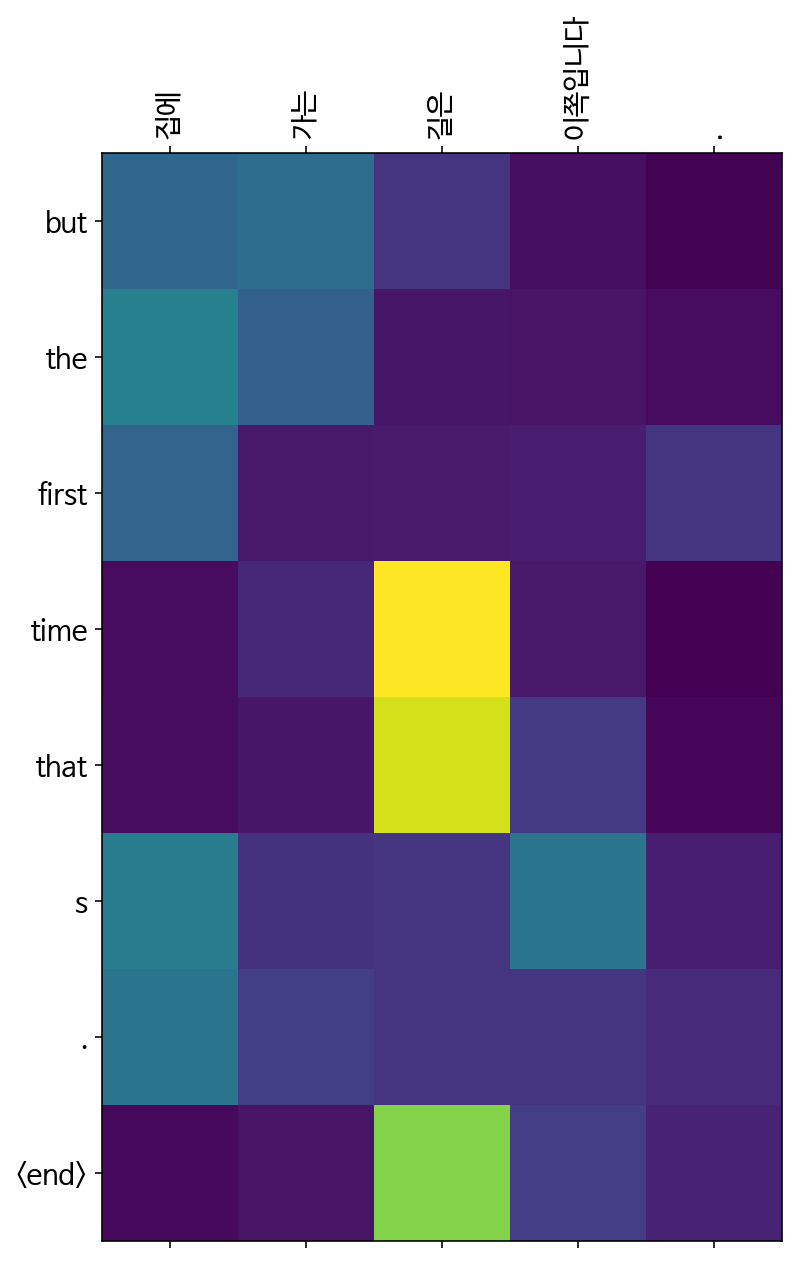

In [ ]:
translate("집에 가는 길은 이쪽입니다.", encoder, decoder)

```
## 예문 ##
K1) 오바마는 대통령이다.
K2) 시민들은 도시 속에 산다.
K3) 커피는 필요 없다.
K4) 일곱 명의 사망자가 발생했다.

## 제출 ##
E1) obama is the president . <end>
E2) people are victims of the city . <end>
E2) the price is not enough . <end>
E2) seven people have died . <end>
````


Input: 오바마는 대통령이다 .
Predicted translation: obama s a new york cnn <end> 


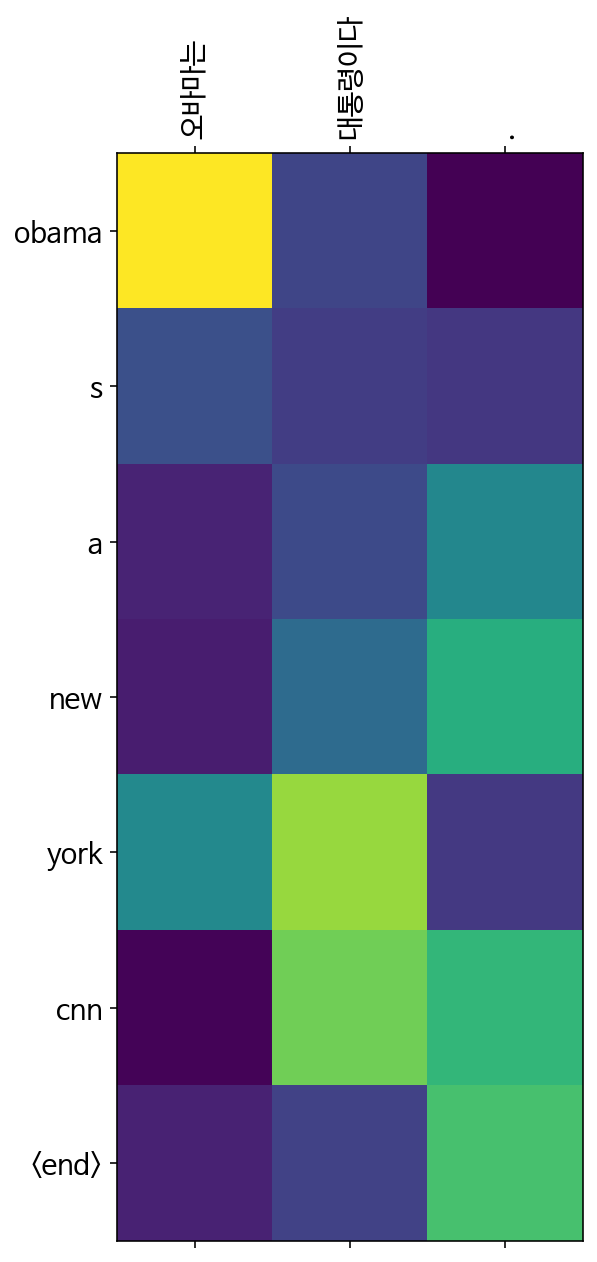

In [ ]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: two people were killed in the united states . <end> 


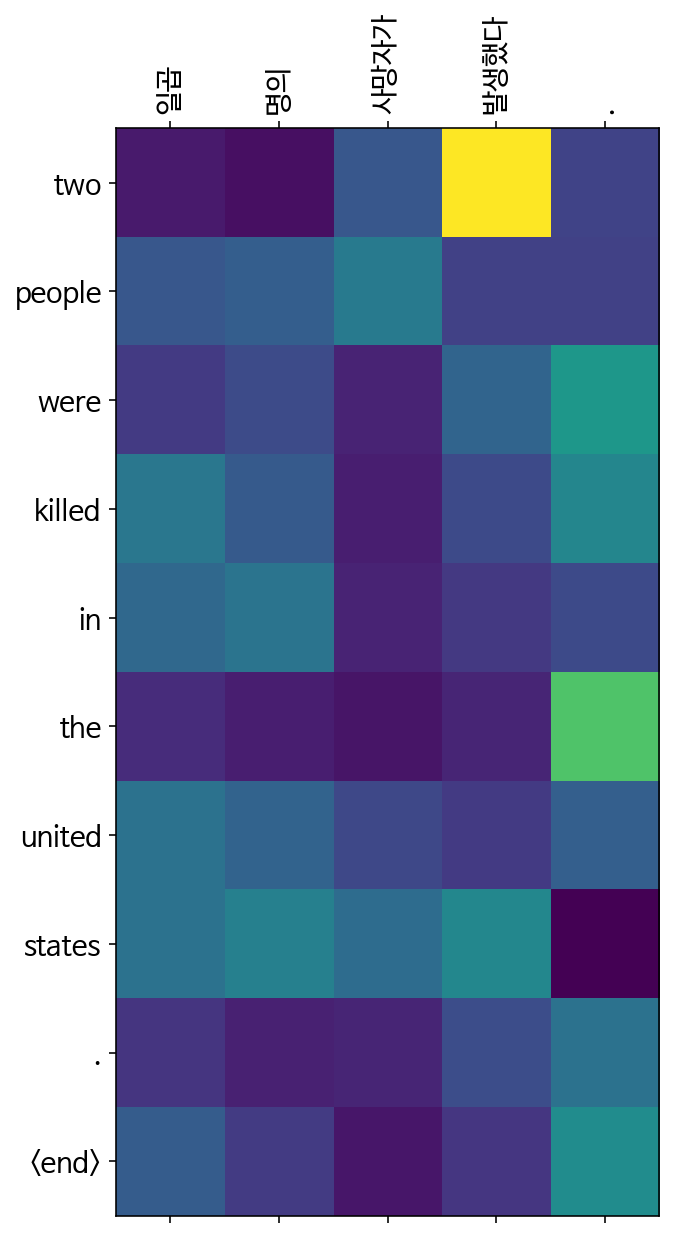

In [ ]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: i have been held in the country s mother . <end> 


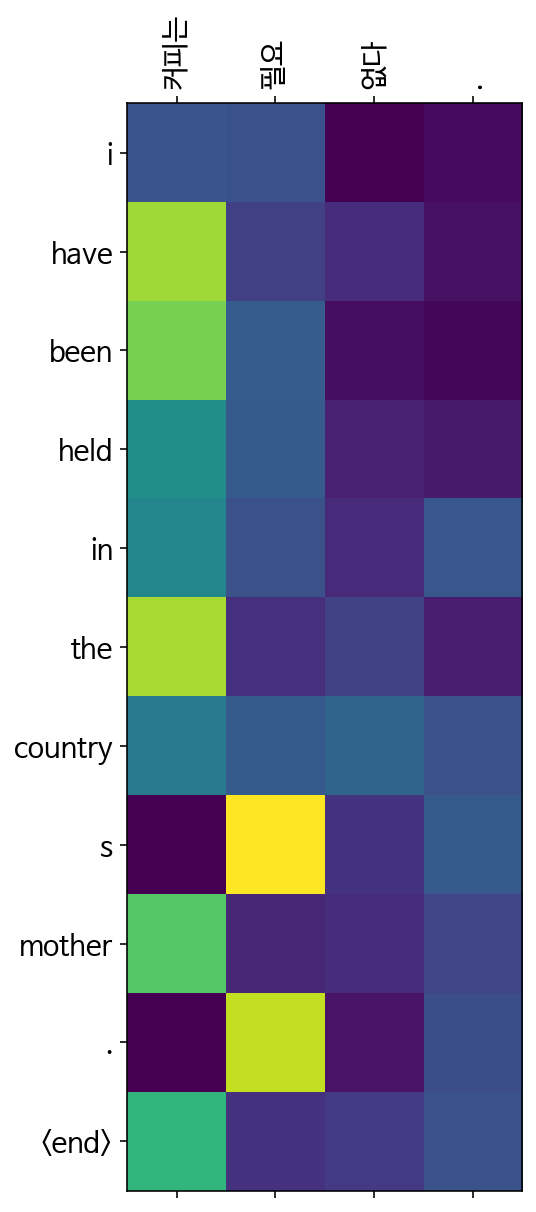

In [ ]:
translate("커피는 필요 없다.", encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: the first time . <end> 


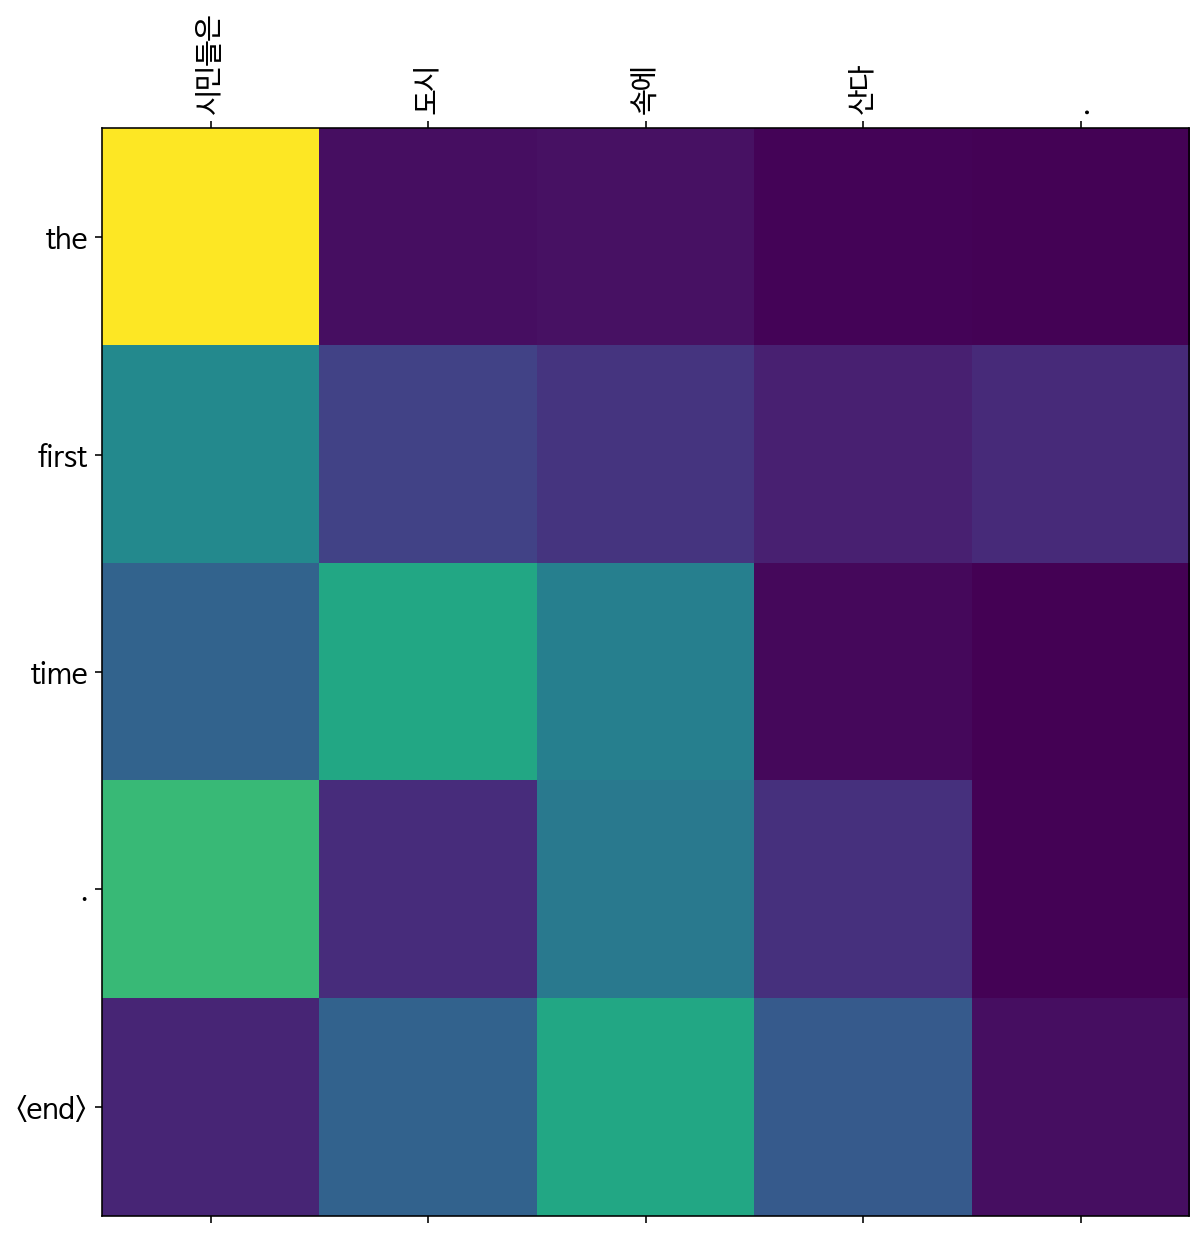

In [ ]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

## 3. 회고

### 3-1. 최종 정리
* 한글, 영어 데이터 불러와서 전처리하고 훈련시키는 것 까지는 재미있었는데, 결과가 제대로 나오지 않아 아쉬웠다... 번역기라고 말할 수 없는 결과... 무엇이 잘못되었는지 알 수 없어서 더 힘들었다. 

* 그래도 Seq2seq, Attention 등을 이해할 수 있는 좋은 시간이었다. 앞으로 관련 내용을 좀 더 찾아보고 정리해봐야겠다. 

<br/>
<br/>

### 3-2. 프로젝트를 진행하면서 알아낸 점, 혹은 아직 모호한 점
* 의미없이 이어지는 문장      
  <img src = "https://drive.google.com/uc?id=1rB0eb4TqmBdPaYI4CYMYNKTVNaMliMR0">

<br/>
<br/>

### 3-3. 참고사이트
* 시퀀스-투-시퀀스       
  https://wikidocs.net/24996      


* 케라스(Keras)의 get_file 함수      
  http://www.gisdeveloper.co.kr/?p=8879        
        
  
* 파이썬의 zip() 내장 함수로 데이터 엮기     
  https://www.daleseo.com/python-zip/    
        
